# Notebook du projet : Analyse des discours de la Banque Centrale Européenne

Dans ce notebook, nous cherchons à analyser différents aspects des discours du comité exécutif de la BCE depuis sa création.

## Package installation

In [ ]:
### Installation de tous les packages nécessaires à l'exécution du notebook 
# Cette étape peut être assez longue

# !pip install -r requirements.txt

## Imports

In [1]:
import time
import datetime
import copy as c
import random
import collections
import re
from itertools import chain


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'

import langdetect
import nltk
import gensim
import datasets
import pyLDAvis
import pyLDAvis.gensim_models
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

# pour l'analyse de sentiments
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pysentiment2 as ps
lm = ps.LM()


import yfinance as yf

# pour importer:exporter des données vers MinIO (répertoire SSP Cloud)
import s3fs
import os

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor



# Fichiers .py du projet
import webscrap
import cleanup 
import statdes
import basic_nlp



ModuleNotFoundError: No module named 'plotly'

## Récupération des discours depuis le site de la BCE

Le dataset des discours est mis à jour tous les mois. Ainsi, même s'il est possible de changer le lien "à la main", il parait pertinent d'utiliser le webscraping pour obtenir la dernière version des données automatiquement. On utilise pour cela les fonctions du fichier *webscrap.py*.

In [19]:
# URL de la page de téléchargement du dataset sur le site de la BCE
url_ecb_download = "https://www.ecb.europa.eu/press/key/html/downloads.en.html"

# On fait du webscraping pour obtenir le lien de la dernière version du dataset des discours
url = "https://www.ecb.europa.eu" + webscrap.get_dataset_url(url_ecb_download)

# On affiche la date de la dernière mise à jour du fichier .csv
print(webscrap.last_update_dataset(url_ecb_download))

df = pd.read_csv(url, sep = "|", encoding = 'utf-8')
print("Il y a ", len(df), "discours dans le dataset.")

last update: 01 January 2022
Il y a  2553 discours dans le dataset


## Nettoyage des données récupérées

Pour le nettoyage des données récupérées, on utilise les fonctions du fichier *cleanup.py*.

Après une analyse préliminaire, on remarque que pour certains discours, on a seulement le titre et le speaker mais le contenu est *NaN*. Il faut donc mettre de côté tous ces discours sans contenu. Ce cas se présente seulement pour 39 discours (soit 1,5% de la base de données). Ainsi, il n'est pas problématique de les retirer.

In [20]:
# On nettoie les données et on affiche les valeurs manquantes
df = cleanup.clean_missing_data(df)

date         0
speakers     2
title        0
subtitle     1
contents    39
dtype: int64


De plus, on décide de ne garder que les discours en anglais. En effet, avoir des discours en plusieurs langues va grandement compliquer le traitement et l'analyse, d'autant plus que la majorité des discours sont en anglais. Pour trier les discours selon leur langue, on a comparé plusieurs méthodes qu'on peut retrouver dans le notebook *Tests-LanguageDetection.ipynb* du dossier *tests*. On utilise ici la méthode qu'on juste la plus adaptée à notre projet alliant rapidité et une efficacité convenable : on analyse les 2000 premiers caractères des discours avec la fonction *detect* de la librairie langdetect.

In [21]:
df = cleanup.keep_english(df)
print("Il reste", len(df), "discours dans le dataframe.")

Proportion de discours en anglais :  0.9287703939514524
Temps pris par cette méthode :  20.47025752067566
Il reste 2334 discours dans le dataframe.


Pour la suite de l'analyse, en particulier pour les statistiques descriptives et les graphiques, il parait opportun d'ajouter au dataframe des colonnes pour le jour, le mois et l'année établis à partir de la colonne "date".

In [22]:
df = cleanup.add_date(df)

C:\Users\Antoine\central-bank-speech-analysis\cleanup.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Antoine\central-bank-speech-analysis\cleanup.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Antoine\central-bank-speech-analysis\cleanup.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



On peut enregistrer le dataframe pour ne pas devoir relancer le début à chaque fois. Pour des questions pratiques, on préférera récupérer directement le fichier depuis  SSP Cloud.

In [23]:
# cleanup.todisk(df)
# df = cleanup.fromdisk()

#On récupère directement le dataset nettoyé à partir de MinIO
url="https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/clean_ecb_speeches_dataset.csv"

df=pd.read_csv(url,sep = ",",encoding='utf-8')

# Statistiques descriptives de notre jeu de données

Avant de commencer l'analyse de sentiments ou le NLP, on analyse d'abord notre jeu de données en faisant des statistiques descriptives en utilisant les fonctions du fichier *statdes.py*.

## Répartition des discours dans le temps

### Nombre de discours par an

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par Année'}, xlabel='Année'>

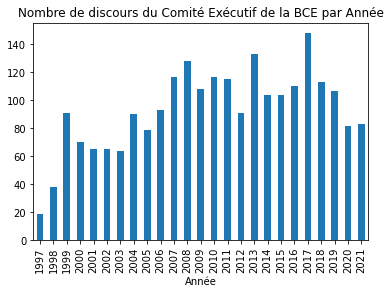

In [24]:
statdes.count_speeches(df, kind = 'bar')

Depuis la création de la Banque Centrale européenne, on constate une hausse significative du nombre de discours du comité exécutif de la BCE : aucune année ne dépasse 100 discours jusqu'en 2006 alors que depuis le nombre de discours n'a été inférieur à 100 qu'en 2012, 2020 et 2021, avec une situation exceptionnelle (crise sanitaire mondiale) pour ces deux dernières années. On pourrait émettre l'hypothèse que les pics du graphique correspondent aux crises : crise des subprimes en 2008, Brexit en 2017 par exemple.

### Nombre de discours selon les mois

<Figure size 432x288 with 0 Axes>

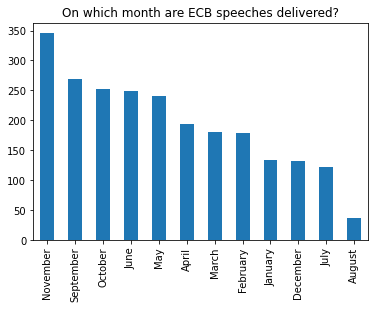

In [28]:
statdes.speech_months(df)

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par Mois'}, xlabel='Mois'>

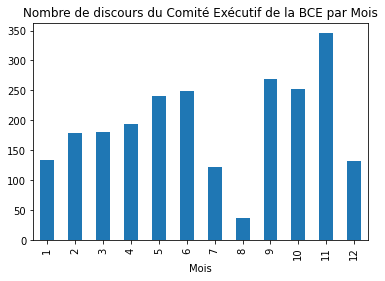

In [25]:
statdes.count_speeches(df, groupingby = 'Month', kind = 'bar')

On constate une forte saisonnalité des discours à la BCE : la plupart des discours sont prononcés pendant les trois mois de la "rentrée" (septembre, octobre, novembre) avec un maximum en novembre mais aussi dans une moindre mesure pendant les trois mois avant l'été (avril, mai, juin). Le nombre de discours chute pendant la période des vacances d'été (juillet et août), particulièrement en août.

### Nombre de discours selon les jours du mois

<AxesSubplot:title={'center':'Evolution du nombre de discours du Comité Exécutif de la BCE par Jour du mois'}, xlabel='Jour du mois'>

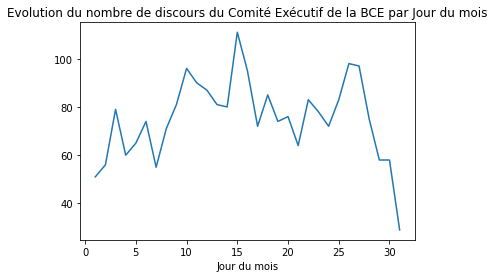

In [34]:
statdes.count_speeches(df, groupingby = 'Day', kind = 'line')

Les pics du graphique correspondent au milieu du mois qui est souvent le moment d'annonces sur les marchés et quelques jours avant la fin du mois.

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par Jour de la semaine'}, xlabel='Jour de la semaine'>

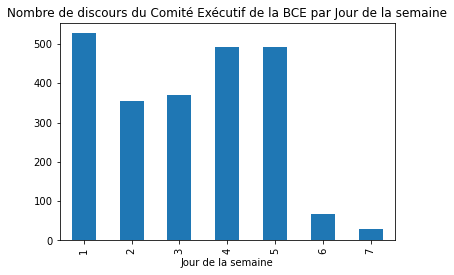

In [32]:
statdes.count_speeches(df, groupingby = 'DayofWeek', kind = 'bar')

On remarque que les discours de la BCE de notre échantillon ne sont pas répartis identiquement selon les jours de la semaine : ils sont majoritairement prononcés le premier jour de la semaine (lundi) et les deux jours avant le week-end (jeudi et vendredi), avec une chute conséquente le samedi et le dimanche, qui sont aussi les jours de fermeture des marchés boursiers dans le monde.

In [29]:
statdes.distinct_dates(df)

Il y a 1807 dates distinctes dans ce jeu de données, soit en moyenne environ 0.774 discours par jour.
Il y a 416 jours pour lesquels plus qu'un seul discours, soit 23.02 % de l'échantillon étudié.
Il y a 330 jours pour lesquels on a 2 discours.
Il y a 65 jours pour lesquels on a 3 discours.
Il y a 17 jours pour lesquels on a 4 discours.
Il y a 4 jours pour lesquels on a 5 discours.


### Orateurs les plus prolifiques du Comité Exécutif de la BCE depuis 1997

<Figure size 432x288 with 0 Axes>

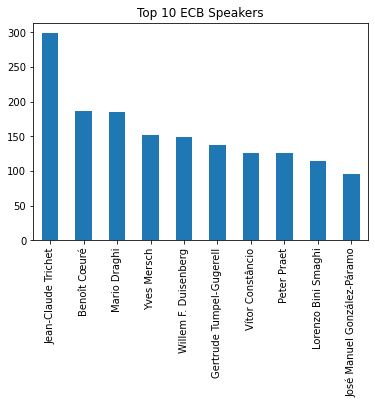

In [33]:
statdes.top_speakers(df, n=10)

Parmi les orateurs les plus prolifiques, on retrouve assez logiquement les anciens présidents de la BCE : Jean-Claude Trichet (2003-2011), Mario Draghi (20011-2019) et Willem Duisenberg (1998-2003) mais aussi Benoît Coeuré et Yves Mersch, membres du directoire de la Banque centrale européenne de 2012 à 2020.

## Exploration des discours avec du NLP

On utilise pour cela les fonctions du fichier *basic_nlp.py*.

In [36]:
# On prend un échantillon des discours 
# car on ne peut pas tous les mettre bout à bout
rawtext = basic_nlp.randomsample(df)
rawtext[:200]

"The ECB's enhanced credit support  The ECB’s enhanced credit support   Keynote address by Jean-Claude Trichet, President of the ECBat the University of MunichMunich, 13 July 2009      Introduction    "

### Reconnaissance d'entités nommées avec spacy

In [37]:
basic_nlp.named_entity(rawtext)

The ECB's enhanced credit support  The ECB’s enhanced credit support   Keynote address by Jean-Claude Trichet, President of the ECBat the University of MunichMunich, 13 July 2009      Introduction    Ladies and gentlemen, It is a pleasure to be in Munich today and speak at this renowned university with its strong economics faculty. I would like to thank the organisers, Professor Hans-Werner Sinn of CESifo and Marc Beise, the chief economics editor of Süddeutsche Zeitung, for inviting me here. I am delighted to have this opportunity to talk about the ECB’s policy actions in these times of exceptional challenges for monetary policy-makers. I also hope to contribute to the academic debate on monetary policy. An active exchange of views between academic and policy-making circles is important for both sides.  The Munich seminars have become one of the best-known events of their kind in Europe. More events of this type are needed. CESifo – with its close links to the University of Munich – h

In [38]:
basic_nlp.freq_mots(rawtext)

Counter({'ECB': 40,
         'enhanced': 17,
         'credit': 52,
         'support': 27,
         'Keynote': 1,
         'address': 8,
         'Jean': 2,
         'Claude': 2,
         'Trichet': 2,
         'President': 2,
         'ECBat': 1,
         'University': 3,
         'MunichMunich': 1,
         'July': 2,
         'Introduction': 2,
         'Ladies': 3,
         'gentlemen': 2,
         'pleasure': 2,
         'Munich': 6,
         'today': 13,
         'speak': 3,
         'renowned': 1,
         'university': 1,
         'strong': 6,
         'economics': 6,
         'faculty': 1,
         'like': 14,
         'thank': 2,
         'organisers': 2,
         'Professor': 1,
         'Hans': 2,
         'Werner': 2,
         'Sinn': 2,
         'CESifo': 3,
         'Marc': 1,
         'Beise': 1,
         'chief': 1,
         'editor': 1,
         'Süddeutsche': 1,
         'Zeitung': 1,
         'inviting': 2,
         'delighted': 1,
         'opportunity': 4,
      

In [23]:
basic_nlp.liste_mots(rawtext)

SyntaxError: unexpected EOF while parsing (<ipython-input-23-0bc1962835c8>, line 1)

In [11]:
basic_nlp.plus_frequents(rawtext, 20)

[['policy', 133],
 ['inflation', 122],
 ['central', 115],
 ['money', 111],
 ['monetary', 106],
 ['bank', 90],
 ['price', 86],
 ['ECB', 70],
 ['currency', 70],
 ['banks', 68],
 ['euro', 63],
 ['economy', 60],
 ['prices', 56],
 ['area', 54],
 ['stability', 50],
 ['time', 48],
 ['economic', 48],
 ['value', 46],
 ['CBDCs', 45],
 ['financial', 42]]

In [5]:
text = basic_nlp.tokens_filter(rawtext)
basic_nlp.word_counter(text, 20)

[('policy', 91),
 ('monetary', 89),
 ('euro', 80),
 ('banks', 77),
 ('central', 68),
 ('inflation', 57),
 ('area', 52),
 ('price', 50),
 ('growth', 44),
 ('stability', 44),
 ('ECB', 42),
 ('economic', 39),
 ('Slovakia', 34),
 ('bank', 34),
 ('European', 31),
 ('independence', 31),
 ('crisis', 30),
 ('economy', 25),
 ('effects', 24),
 ('financial', 23)]

In [9]:
bigrams = basic_nlp.get_bigrams(text)
basic_nlp.print_bigram_likelihood(bigrams)

(('euro', 'area'), 476.7994710774498)
(('monetary', 'policy'), 387.6855430749108)
(('price', 'stability'), 357.12592790428243)
(('United', 'States'), 201.07769026933568)
(('single', 'currency'), 160.74495386505185)
(('Governing', 'Council'), 132.09057700270793)
(('interest', 'rates'), 126.26596502251313)
(('medium', 'term'), 111.8124825171779)
(('public', 'debt'), 101.86237455246537)
(('sustained', 'adjustment'), 101.77956790853109)
(('economic', 'growth'), 101.17853158219808)
(('asset', 'purchases'), 99.09699345047102)
(('primary', 'objective'), 98.42258979491885)
(('Working', 'Paper'), 97.26286866533923)
(('resource', 'allocation'), 97.26286866533923)
(('structural', 'reforms'), 93.4633895800244)
(('financial', 'integration'), 91.16938916739385)
(('private', 'sector'), 89.73948561604054)
(('European', 'Union'), 84.73088262135778)
(('net', 'asset'), 83.8026353251541)
(('Growth', 'Pact'), 82.47746380112385)
(('Member', 'States'), 80.8582741509297)
(('Stability', 'Growth'), 78.955427331

In [10]:
trigrams = basic_nlp.get_trigrams(text)
basic_nlp.print_trigram_likelihood(trigrams)

(('within', 'euro', 'area'), 750.4915343530893)
(('performance', 'euro', 'area'), 744.7958319331979)
(('euro', 'area', 'whole'), 743.5163551472615)
(('euro', 'area', 'economy'), 740.5448604628822)
(('euro', 'area', 'countries'), 739.0054101150502)
(('growth', 'euro', 'area'), 735.2643990494814)
(('stability', 'euro', 'area'), 729.6246800368411)
(('euro', 'area', 'growth'), 727.8449536801643)
(('monetary', 'policy', 'strategy'), 622.1560134515399)
(('single', 'monetary', 'policy'), 617.8844003339462)
(('accommodative', 'monetary', 'policy'), 616.8472241456639)
(('maintain', 'price', 'stability'), 614.7490293412278)
(('monetary', 'policy', 'response'), 614.5079196849128)
(('objective', 'price', 'stability'), 603.3765430812368)
(('rate', 'United', 'States'), 355.8196637926659)
(('net', 'asset', 'purchases'), 285.92735048965756)
(('Stability', 'Growth', 'Pact'), 263.7901023073545)
(('Governing', 'Council', 'ECB'), 245.61717600892416)
(('sustained', 'adjustment', 'inflation'), 234.032537496

In [5]:
basic_nlp.year_speeches(df, 2008)

'The changing role of communication  The changing role of communication   Introductory Remarks by Jean-Claude Trichet, President of the ECBat a dinner with members of the Internationaler Club Frankfurter Wirtschaftsjournalisten Frankfurt am Main,15 December 2008 Ladies and gentlemen,  A very warm welcome to all of you and thank you very much for your invitation to this club evening. I am happy to see many familiar faces in the audience tonight. Communication is a very important issue for all times. Being here in Frankfurt I am thinking of the very profound remark by Goethe: “Niemand würde in Gesellschaften viel sprechen, wenn er sich bewuβt wäre, wie oft er die anderen missversteht“. Nevertheless let me be bold enough to share with you some thoughts on communication and central banks. Communication is a key element for central banks to enhance the effectiveness, predictability and credibility of their monetary policy decisions. It becomes even more important in difficult times, when th

<BarContainer object of 20 artists>

<Figure size 432x288 with 0 Axes>

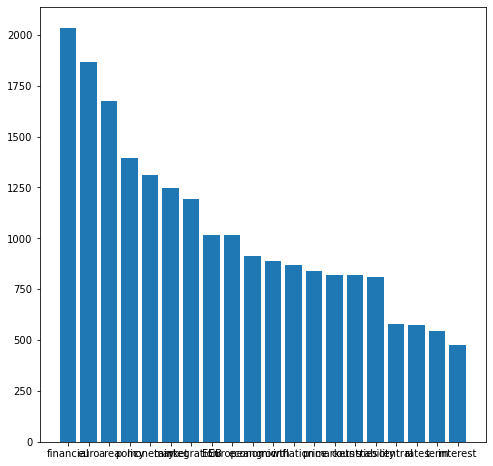

In [6]:
basic_nlp.plot_freq_word(df, 2005)

In [13]:
basic_nlp.freq_words_year(df, 2005, 20)

[('financial', 2035),
 ('euro', 1865),
 ('area', 1676),
 ('policy', 1395),
 ('monetary', 1310),
 ('market', 1245),
 ('integration', 1191),
 ('ECB', 1016),
 ('European', 1015),
 ('economic', 911),
 ('growth', 887),
 ('inflation', 869),
 ('price', 840),
 ('markets', 819),
 ('countries', 819),
 ('stability', 811),
 ('central', 578),
 ('rates', 575),
 ('term', 543),
 ('interest', 477)]

# Latent Dirichlet Allocation (LDA)

LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.

### Notebook établi à partir de : 
- https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb 
    - https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#### Autres ressources intéressantes

Autre article similaire sur la LDA :
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
    - https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb
    
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#1introduction

##### Aspect visualisation
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ 

##### Scikit-learn
- https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation
- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html


# Reading data

In [4]:
data=df.sample(frac=0.6,random_state=1) #on n'applique la LDA que sur une portion du dataset pour pouvoir tester le modèle par la suite

#### Tokenization

In [9]:
data['sentences'] = data.contents.progress_map(nltk.tokenize.sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

  0%|          | 0/1398 [00:00<?, ?it/s]

['   SPEECH  Learning from Lisbon: recovery and resilience in Europe   Speech by Christine Lagarde, President of the ECB, on the occasion of the 175th anniversary of Banco de Portugal in Lisbon Lisbon, 3 November 2021 Introduction I am delighted to be here in Lisbon to celebrate the 175th anniversary of the Banco de Portugal, an institution that can be proud of its contribution to Portuguese history.',
 'And it is a history that is fused with Europe.',
 'Lisbon was home to the peaceful Carnation Revolution of 1974, which ushered in democracy and marked a crucial step towards Portugal’s membership of the European Community.']

In [10]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [nltk.tokenize.word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])

  0%|          | 0/1398 [00:00<?, ?it/s]

[['SPEECH', 'Learning', 'from', 'Lisbon', ':', 'recovery', 'and', 'resilience', 'in', 'Europe', 'Speech', 'by', 'Christine', 'Lagarde', ',', 'President', 'of', 'the', 'ECB', ',', 'on', 'the', 'occasion', 'of', 'the', '175th', 'anniversary', 'of', 'Banco', 'de', 'Portugal', 'in', 'Lisbon', 'Lisbon', ',', '3', 'November', '2021', 'Introduction', 'I', 'am', 'delighted', 'to', 'be', 'here', 'in', 'Lisbon', 'to', 'celebrate', 'the', '175th', 'anniversary', 'of', 'the', 'Banco', 'de', 'Portugal', ',', 'an', 'institution', 'that', 'can', 'be', 'proud', 'of', 'its', 'contribution', 'to', 'Portuguese', 'history', '.'], ['And', 'it', 'is', 'a', 'history', 'that', 'is', 'fused', 'with', 'Europe', '.'], ['Lisbon', 'was', 'home', 'to', 'the', 'peaceful', 'Carnation', 'Revolution', 'of', '1974', ',', 'which', 'ushered', 'in', 'democracy', 'and', 'marked', 'a', 'crucial', 'step', 'towards', 'Portugal', '’', 's', 'membership', 'of', 'the', 'European', 'Community', '.']]


#### Lemmatizing with POS tagging

In [11]:
#################################################################

# ETAPE LA PLUS CHRONOPHAGE
# 4 minutes pour 1400 discours

################################################################

data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [nltk.pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/1398 [00:00<?, ?it/s]

[[('SPEECH', 'NNP'), ('Learning', 'NNP'), ('from', 'IN'), ('Lisbon', 'NNP'), (':', ':'), ('recovery', 'NN'), ('and', 'CC'), ('resilience', 'NN'), ('in', 'IN'), ('Europe', 'NNP'), ('Speech', 'NNP'), ('by', 'IN'), ('Christine', 'NNP'), ('Lagarde', 'NNP'), (',', ','), ('President', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('ECB', 'NNP'), (',', ','), ('on', 'IN'), ('the', 'DT'), ('occasion', 'NN'), ('of', 'IN'), ('the', 'DT'), ('175th', 'JJ'), ('anniversary', 'NN'), ('of', 'IN'), ('Banco', 'NNP'), ('de', 'FW'), ('Portugal', 'NNP'), ('in', 'IN'), ('Lisbon', 'NNP'), ('Lisbon', 'NNP'), (',', ','), ('3', 'CD'), ('November', 'NNP'), ('2021', 'CD'), ('Introduction', 'NNP'), ('I', 'PRP'), ('am', 'VBP'), ('delighted', 'VBN'), ('to', 'TO'), ('be', 'VB'), ('here', 'RB'), ('in', 'IN'), ('Lisbon', 'NNP'), ('to', 'TO'), ('celebrate', 'VB'), ('the', 'DT'), ('175th', 'JJ'), ('anniversary', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Banco', 'NNP'), ('de', 'FW'), ('Portugal', 'NNP'), (',', ','), ('an', 'DT'), ('ins

In [12]:
# Inspired from https://stackoverflow.com/a/15590384

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return ''

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

In [13]:
# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

  0%|          | 0/1398 [00:00<?, ?it/s]

In [14]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['SPEECH',
  'Learning',
  'from',
  'Lisbon',
  ':',
  'recovery',
  'and',
  'resilience',
  'in',
  'Europe',
  'Speech',
  'by',
  'Christine',
  'Lagarde',
  ',',
  'President',
  'of',
  'the',
  'ECB',
  ',',
  'on',
  'the',
  'occasion',
  'of',
  'the',
  '175th',
  'anniversary',
  'of',
  'Banco',
  'de',
  'Portugal',
  'in',
  'Lisbon',
  'Lisbon',
  ',',
  '3',
  'November',
  '2021',
  'Introduction',
  'I',
  'be',
  'delight',
  'to',
  'be',
  'here',
  'in',
  'Lisbon',
  'to',
  'celebrate',
  'the',
  '175th',
  'anniversary',
  'of',
  'the',
  'Banco',
  'de',
  'Portugal',
  ',',
  'an',
  'institution',
  'that',
  'can',
  'be',
  'proud',
  'of',
  'its',
  'contribution',
  'to',
  'Portuguese',
  'history',
  '.'],
 ['And',
  'it',
  'be',
  'a',
  'history',
  'that',
  'be',
  'fuse',
  'with',
  'Europe',
  '.'],
 ['Lisbon',
  'be',
  'home',
  'to',
  'the',
  'peaceful',
  'Carnation',
  'Revolution',
  'of',
  '1974',
  ',',
  'which',
  'usher',
  

#### Regrouping tokens and removing stop words

In [15]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = basic_nlp.stop_words + stopwords_verbs + stopwords_other

In [17]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [18]:
data['tokens'].head(1).tolist()[0][:30]

['speech',
 'learning',
 'lisbon',
 'recovery',
 'resilience',
 'europe',
 'speech',
 'christine',
 'lagarde',
 'president',
 'ecb',
 'occasion',
 'anniversary',
 'banco',
 'portugal',
 'lisbon',
 'lisbon',
 'november',
 'introduction',
 'delight',
 'lisbon',
 'celebrate',
 'anniversary',
 'banco',
 'portugal',
 'institution',
 'proud',
 'contribution',
 'portuguese',
 'history']

# LDA

## Data preparation

#### Prepare bi-grams and tri-grams

In [19]:
tokens = data['tokens'].tolist()
bigram_model = gensim.models.Phrases(tokens)
trigram_model = gensim.models.Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [20]:
dictionary_LDA = gensim.corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

## Running LDA

In [74]:
np.random.seed(123456)
num_topics = 9
%time lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 23.5 s


## Quick exploration of LDA results

#### Looking at topics

In [75]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.009*"statistic" + 0.004*"data" + 0.004*"monetary" + 0.004*"think" + 0.004*"information" + 0.003*"financial_stability" + 0.003*"analysis" + 0.003*"strategy" + 0.002*"money" + 0.002*"currency" + 0.002*"financial_system" + 0.002*"question" + 0.002*"indicator" + 0.002*"duisenberg" + 0.002*"eurosystem" + 0.002*"integration" + 0.002*"international" + 0.002*"experience" + 0.002*"liquidity" + 0.002*"world"

1: 0.004*"model" + 0.003*"expectation" + 0.003*"uncertainty" + 0.003*"shock" + 0.003*"international" + 0.002*"might" + 0.002*"inflation_expectation" + 0.002*"data" + 0.002*"liquidity" + 0.002*"domestic" + 0.002*"rise" + 0.002*"response" + 0.002*"instrument" + 0.002*"united_states" + 0.002*"chart" + 0.002*"factor" + 0.002*"recovery" + 0.002*"likely" + 0.002*"estimate" + 0.002*"affect"

2: 0.008*"sepa" + 0.005*"payment" + 0.003*"eurosystem" + 0.003*"liquidity" + 0.003*"retail_payment" + 0.002*"new_member_states" + 0.002*"service" + 0.002*"international" + 0.002*"strategy" + 0.002*"financ

#### Allocating topics to documents

In [76]:
print(data.contents.loc[0][:500])

   SPEECH  Learning from Lisbon: recovery and resilience in Europe   Speech by Christine Lagarde, President of the ECB, on the occasion of the 175th anniversary of Banco de Portugal in Lisbon Lisbon, 3 November 2021 Introduction I am delighted to be here in Lisbon to celebrate the 175th anniversary of the Banco de Portugal, an institution that can be proud of its contribution to Portuguese history. And it is a history that is fused with Europe. Lisbon was home to the peaceful Carnation Revolutio


In [77]:
lda_model[corpus[0]]

[(1, 0.10614286), (3, 0.89374834)]

#### Predicting topics on unseen documents

In [78]:
document = '''The Governing Council judges that the progress on economic recovery and towards its medium-term inflation target permits a step-by-step reduction in the pace of its asset purchases over the coming quarters. But monetary accommodation is still needed for inflation to stabilise at the 2% inflation target over the medium term. In view of the current uncertainty, the Governing Council needs to maintain flexibility and optionality in the conduct of monetary policy. With this is mind, the Governing Council took the following decisions:

Pandemic emergency purchase programme (PEPP)
In the first quarter of 2022, the Governing Council expects to conduct net asset purchases under the PEPP at a lower pace than in the previous quarter. It will discontinue net asset purchases under the PEPP at the end of March 2022.

The Governing Council decided to extend the reinvestment horizon for the PEPP. It now intends to reinvest the principal payments from maturing securities purchased under the PEPP until at least the end of 2024. In any case, the future roll-off of the PEPP portfolio will be managed to avoid interference with the appropriate monetary policy stance.

The pandemic has shown that, under stressed conditions, flexibility in the design and conduct of asset purchases has helped to counter the impaired transmission of monetary policy and made efforts to achieve the Governing Council’s goal more effective. Within our mandate, under stressed conditions, flexibility will remain an element of monetary policy whenever threats to monetary policy transmission jeopardise the attainment of price stability. In particular, in the event of renewed market fragmentation related to the pandemic, PEPP reinvestments can be adjusted flexibly across time, asset classes and jurisdictions at any time. This could include purchasing bonds issued by the Hellenic Republic over and above rollovers of redemptions in order to avoid an interruption of purchases in that jurisdiction, which could impair the transmission of monetary policy to the Greek economy while it is still recovering from the fallout of the pandemic. Net purchases under the PEPP could also be resumed, if necessary, to counter negative shocks related to the pandemic.

Asset purchase programme (APP)
In line with a step-by-step reduction in asset purchases and to ensure that the monetary policy stance remains consistent with inflation stabilising at its target over the medium term, the Governing Council decided on a monthly net purchase pace of €40 billion in the second quarter and €30 billion in the third quarter under the APP. From October 2022 onwards, the Governing Council will maintain net asset purchases under the APP at a monthly pace of €20 billion for as long as necessary to reinforce the accommodative impact of its policy rates. The Governing Council expects net purchases to end shortly before it starts raising the key ECB interest rates.

The Governing Council also intends to continue reinvesting, in full, the principal payments from maturing securities purchased under the APP for an extended period of time past the date when it starts raising the key ECB interest rates and, in any case, for as long as necessary to maintain favourable liquidity conditions and an ample degree of monetary accommodation.

Key ECB interest rates
The interest rate on the main refinancing operations and the interest rates on the marginal lending facility and the deposit facility will remain unchanged at 0.00%, 0.25% and -0.50% respectively.

In support of its symmetric 2% inflation target and in line with its monetary policy strategy, the Governing Council expects the key ECB interest rates to remain at their present or lower levels until it sees inflation reaching 2% well ahead of the end of its projection horizon and durably for the rest of the projection horizon, and it judges that realised progress in underlying inflation is sufficiently advanced to be consistent with inflation stabilising at 2% over the medium term. This may also imply a transitory period in which inflation is moderately above target.

Refinancing operations
The Governing Council will continue to monitor bank funding conditions and ensure that the maturing of operations under the third series of targeted longer-term refinancing operations (TLTRO III) does not hamper the smooth transmission of its monetary policy. The Governing Council will also regularly assess how targeted lending operations are contributing to its monetary policy stance. As announced, it expects the special conditions applicable under TLTRO III to end in June next year. The Governing Council will also assess the appropriate calibration of its two-tier system for reserve remuneration so that the negative interest rate policy does not limit banks’ intermediation capacity in an environment of ample excess liquidity.

***

The Governing Council stands ready to adjust all of its instruments, as appropriate and in either direction, to ensure that inflation stabilises at its 2% target over the medium term.

The President of the ECB will comment on the considerations underlying these decisions at a press conference starting at 14:30 CET today.'''
tokens = nltk.tokenize.word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,1,0.80,"0.004*""model"" + 0.003*""expectation"" + 0.003*""u..."
1,4,0.03,"0.004*""integration"" + 0.003*""financial_integra..."
2,6,0.03,"0.007*""liquidity"" + 0.004*""financial_system"" +..."
3,7,0.13,"0.005*""monetary"" + 0.004*""currency"" + 0.004*""i..."


## Advanced exploration of LDA results

#### Allocation of topics in all documents

In [79]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [80]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], num_topics)

,0,1,2,3,4,5,6,7,8,9,15,18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038537,0.091301,0.869287


In [81]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [82]:
document_topic.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.105843,0.000000,0.894049,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,0.033863,0.011571,0.000000,0.116983,0.416051,0.0,0.000000,0.421487
2,0.0,0.000000,0.000000,0.000000,0.277752,0.000000,0.0,0.721339,0.000000
3,0.0,0.000000,0.000000,0.222240,0.777524,0.000000,0.0,0.000000,0.000000
4,0.0,0.399262,0.000000,0.000000,0.600590,0.000000,0.0,0.000000,0.000000


In [83]:
print("Moyenne de la part de chaque topic dans tout le texte")
for i in range(num_topics):
    print("Topic", i,":", document_topic.sort_values(i, ascending=False)[i].mean())

Moyenne de la part de chaque topic dans tout le texte
Topic 0 : 0.04982995848972164
Topic 1 : 0.11377042040191537
Topic 2 : 0.0486875334801219
Topic 3 : 0.08980640219138117
Topic 4 : 0.23849627264350312
Topic 5 : 0.07228218345770956
Topic 6 : 0.07050361746365207
Topic 7 : 0.20091352170434526
Topic 8 : 0.11476201575065567


In [84]:
# Which document are about topic 1
document_topic.sort_values(1, ascending=False)[1]

151     0.999963
132     0.999956
37      0.999949
973     0.999944
998     0.999936
          ...   
544     0.000000
542     0.000000
541     0.000000
540     0.000000
1397    0.000000
Name: 1, Length: 1398, dtype: float64

In [85]:
print(data.contents.loc[91][:1000])

  The importance of independent fiscal councils   Opening remarks by Benoît Cœuré, Member of the Executive Board of the ECB, at the workshop on “Fiscal councils, central banks and sound public finances”, Frankfurt am Main, 27 January 2016  ***   Setting the stage for a workshop at the ECB on fiscal councils, central banks and sound public finances, Benoît Cœuré underlines in his opening remarks that sound public finances in all euro area member countries is a precondition for completing Economic and Monetary Union. Even if these days “there is no appetite for moving towards a ‘United States of Europe’”, he says, “there is a common understanding” that euro area member countries need to further integrate their fiscal and economic policies. Benoît Cœuré focuses on the requirements that need to be met for national fiscal councils and the European Fiscal Board (EFB) to be fully effective. “Independence” is the key word at both national and European levels. The EFB is also charged with the i

#### Looking at the distribution of topics in all documents

C:\Users\Antoine\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\Antoine\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

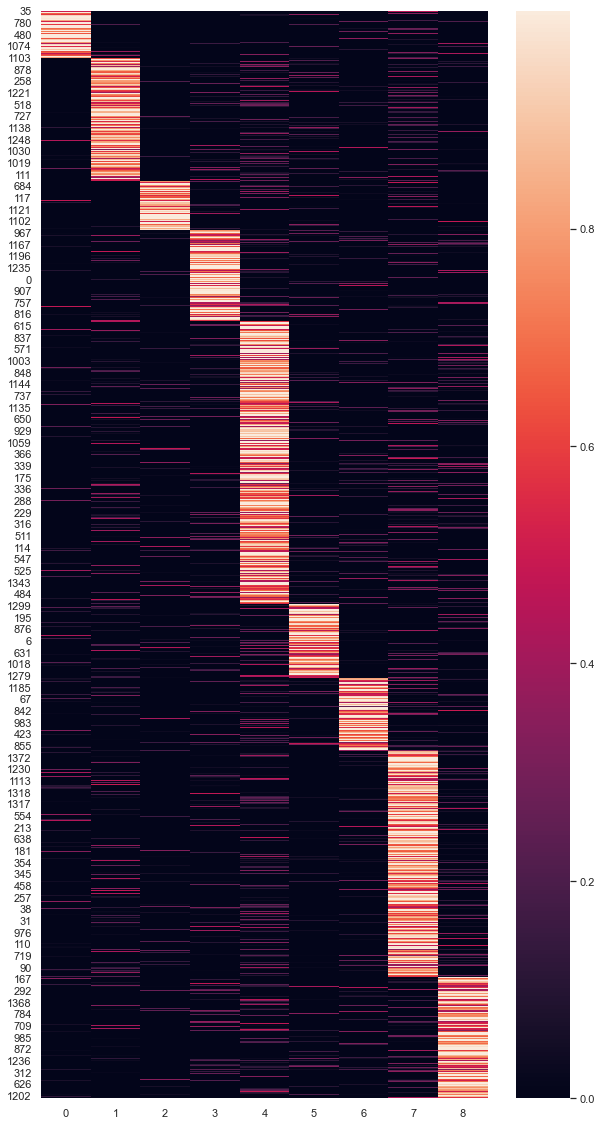

In [86]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

<AxesSubplot:>

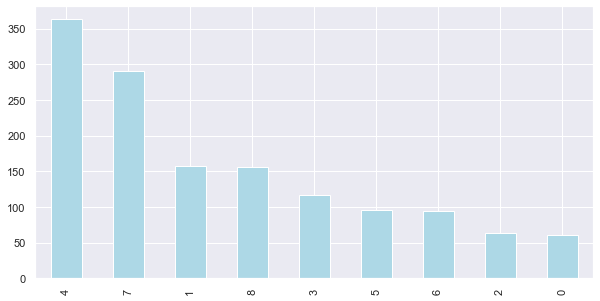

In [87]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#### Visualizing topics

In [88]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline

vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Antoine\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## Perplexity et Coherence

In [89]:

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data['tokens'].tolist(),corpus=corpus, dictionary=dictionary_LDA, coherence='u_mass')
# coherence={'u_mass', 'c_v', 'c_uci', 'c_npmi'}
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_model_lda.get_coherence_per_topic())
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.538993917475457
[-0.9335880694835187, -0.8681291095412934, -1.3619862822090365, -0.8813002352273499, -0.7816061520065525, -0.8821625851993592, -0.8108897247678897, -0.7817865929455753, -0.8023044800176798]

Coherence Score:  -0.9004170257109172


In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute 'u_mass' coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    complexity_values : Complexity values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    complexity_values= []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        complexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, complexity_values

In [41]:
#########################################

# ETAPE CHRONOPHAGE (~10 minutes)

##########################################

start_time=time.time()

model_list, coherence_values, complexity_values = compute_coherence_values(dictionary=dictionary_LDA,
                                                                           corpus=corpus,
                                                                           texts=data['tokens'].tolist(),
                                                                           start=2,
                                                                           limit=20,
                                                                           step=1
                                                                          )
print("Temps pris par cette étape", time.time()-start_time) Temps pris par cette étape 509.70097303390503

Temps pris par cette étape 509.70097303390503


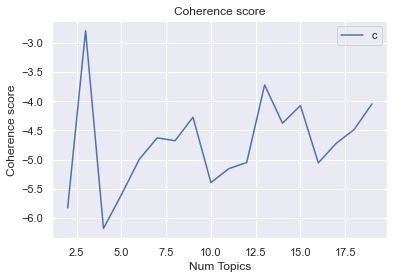

In [42]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

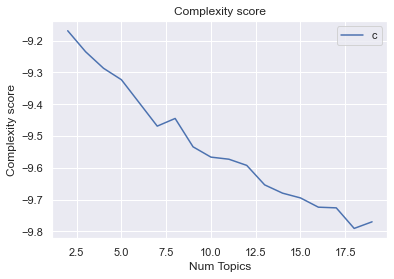

In [43]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, complexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Complexity score")
plt.title("Complexity score")
plt.legend(("complexity_values"), loc='best')
plt.show()

# Sentiment Analysis

# Librairies non spécialisées

In [8]:
# https://ednafernandes.medium.com/three-python-libraries-for-sentiment-analysis-c189655e0d9b
#Article intéressant pour 3 librairies classiques/basiques pour l'analyse de sentiments
# TextBlob
# AFINN
# Vader

## AFINN

In [9]:
afinn = Afinn()
#exemple :
afinn.score('This is utterly excellent!')

3.0

In [10]:
"""from afinn import Afinn
def afinn_polarity(text):
    return Afinn().score(text)
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(afinn_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from afinn import Afinn\ndef afinn_polarity(text):\n    return Afinn().score(text)\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(afinn_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [11]:
#Premier test du score AFINN
start = time.time()
N=random.randrange(0, len(df))
print("Score :", afinn.score(df["contents"][N]))
end = time.time()
print("Temps pris :", end-start)
#Une première estimation donne une durée totale d'analyse d'un peu plus de 6 minutes pour tous les discours

Score : 88.0
Temps pris : 0.12486124038696289


In [12]:
start = time.time()

df["afinn-score"]=pd.Series(dtype=int)
def afinn_score(text):
    return afinn.score(text)

df["afinn-score"]=df["contents"].apply(afinn_score)

end = time.time()
print("Temps pris :", end-start) #~3 minutes

Temps pris : 230.49008059501648


Score moyen : 91.70522707797772
Score médian : 85.0


<AxesSubplot:>

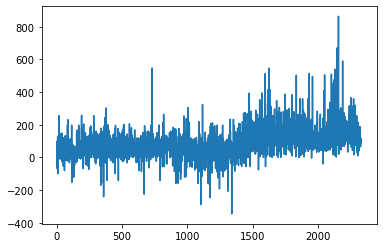

In [13]:
print("Score moyen :", df["afinn-score"].mean())
print("Score médian :",df["afinn-score"].median())

df["afinn-score"].plot()

In [14]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=90
fig=df.rolling(val, on="date").mean().plot(x="date",y="afinn-score",backend='plotly', title="Score AFINN")

fig.show()

## TextBlob

In [13]:
from textblob import TextBlob
def textblob_polarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(textblob_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from textblob import TextBlob\ndef textblob_polarity(text):\n return TextBlob(text).sentiment.polarity\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(textblob_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [14]:
start = time.time()

df["textblob-score"]=pd.Series(dtype=int)
def textblob_score(text):
    return TextBlob(text).sentiment.polarity

df["textblob-score"]=df["contents"].apply(textblob_score)

end = time.time()
print("Temps pris :", end-start) #~40 secondes

Temps pris : 28.913647651672363


Score moyen : 0.1047167025466477
Score médian : 0.10119140438552868


<AxesSubplot:>

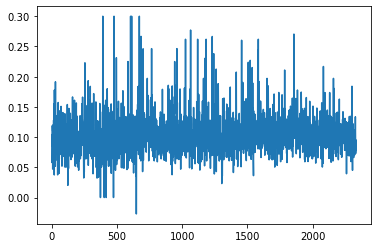

In [15]:
print("Score moyen :", df["textblob-score"].mean())
print("Score médian :",df["textblob-score"].median())

df["textblob-score"].plot()

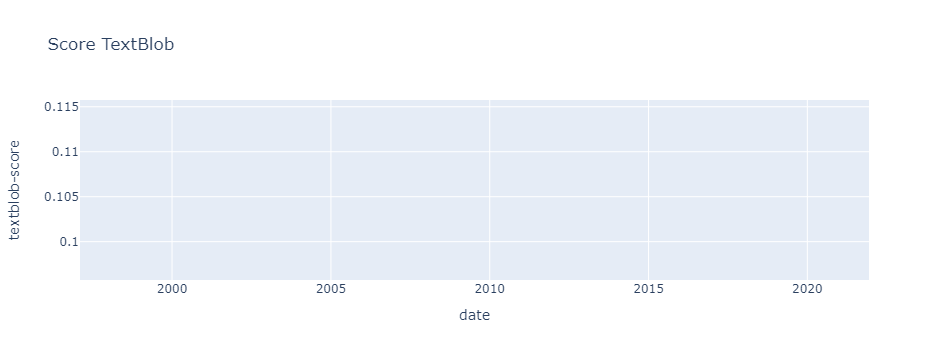

In [16]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=180
fig=df.rolling(val, on="date").mean().plot(x="date",y="textblob-score",backend='plotly', title="Score TextBlob")

fig.show()

## Vader Sentiment Lexicon

In [ ]:
"""from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def varder_polarity(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)
def varder_analysis(score):
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'
df['polarity'] = df[text].apply(varder_analysis)
df['classification'] = df['polarity'].apply(varder_analysis)"""

In [ ]:
##############################

# /!\ plus de 20 minutes /!\

##############################

start = time.time()

# Exemple de résultat de de modèle
# {'neg': 0.029, 'neu': 0.878, 'pos': 0.092, 'compound': 0.9999}
df["vader-score"]=pd.Series(dtype=int)

def vader_score(text):
    #retourne un dictionnaire
    return SentimentIntensityAnalyzer().polarity_scores(text)

def vader_score_compound(text):
    #retourne un float
    return SentimentIntensityAnalyzer().polarity_scores(text)['compound']

#df["vader-score"]=df["contents"].apply(vader_score_compound)

end = time.time()
print("Temps pris :", end-start) #23 minutes

In [ ]:
#print("Score moyen :", df["vader-score"].mean())
#print("Score médian :",df["vader-score"].median())

#df["vader-score"].plot()

## Corrélation entre les différents scores

In [ ]:
df['afinn-score'].corr(df['vader-score'])

In [17]:
df['afinn-score'].corr(df['textblob-score'])

0.13548532009111175

In [ ]:
df['vader-score'].corr(df['textblob-score'])

Les scores sont plus positifs que négatifs en général, mais il faudrait utiliser des librairies plus spécialisées (tournées vers l'économie et la finance).

# Librairies spécialisées

Au cours de nos recherches, plusieurs dictionnaires, listes ou bases de données sont apparus à plusieurs reprises comme des références dans l'analyse de sentiments de textes financiers comme :
- Loughran and McDonald
    - https://sraf.nd.edu/ et https://drive.google.com/file/d/1moS1tkh_AJafpcIFpktaSvZwrzv5d4ix/view
    - https://pypi.org/project/pysentiment2/#description 
- FED Financial Stability dictionary
    - https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203.pdf [REPORT]
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx [DATA]
- 
- Dataset "financial_phrasebank" https://huggingface.co/datasets/financial_phrasebank

## Loughran and McDonald

In [15]:
lm = ps.LM() #to use the Loughran and McDonald dictionary

     |████████████████████████████████| 1.9 MB 972 kB/s            


In [16]:
text=df["contents"][0]


tokens = lm.tokenize(text)
score = lm.get_score(tokens)

score

{'Positive': 125,
 'Negative': 165,
 'Polarity': -0.13793103400713436,
 'Subjectivity': 0.09244501112768728}

### Polarity

In [17]:
def LM_polarity(text):
    '''Pour obtenir la polarité d'un texte selon le dictionnaire Loughran and McDonald'''
    '''Polarity= (Pos-Neg)/(Pos+Neg)'''
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Polarity'],4)

In [18]:
start = time.time()

df["LM-polarity"]=pd.Series(dtype=float)

df["LM-polarity"]=df["contents"].apply(LM_polarity)

end = time.time()
print("Temps pris :", end-start, "secondes")
#Temps pris : 110.3992772102356 secondes

Temps pris : 90.82716679573059 secondes


In [19]:
print("Polarité moyenne :", df["LM-polarity"].mean()) #Polarité moyenne : -0.04744399141630894

print("Polarité médiane :",df["LM-polarity"].median()) #Polarité médiane : -0.06055

Polarité moyenne : -0.04777600685518417
Polarité médiane : -0.06135


### Subjectivity

In [20]:
def LM_subjectivity(text):
    '''Pour obtenir la subjectivité d'un texte selon le dictionnaire Loughran and McDonald'''
    '''Subjectivity= (Pos+Neg)/count'''
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Subjectivity'],4) #on arrondit le résultat

In [21]:
start = time.time()

df["LM-subjectivity"]=pd.Series(dtype=float)
df["LM-subjectivity"]=df["contents"].apply(LM_subjectivity)

end = time.time()
print("Temps pris :", end-start, "secondes")
#Temps pris : 114.29144740104675 secondes

In [22]:
print("Subjectivité moyenne :", df["LM-polarity"].mean()) #Subjectivité moyenne : -0.04744399141630894

print("Subjectivité médiane :",df["LM-polarity"].median()) #Subjectivité médiane : -0.06055

Subjectivité moyenne : -0.04777600685518417
Subjectivité médiane : -0.06135


### Graphiques Polarité et Subjectivité

In [23]:
fig = px.line(df, x="date",y=["LM-polarity","LM-subjectivity"])
fig.show()
#peu lisible

<AxesSubplot:xlabel='Year,Month'>

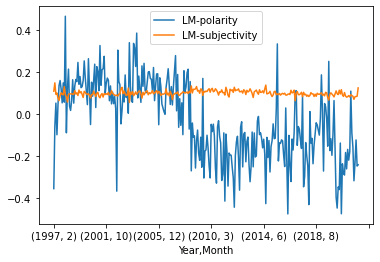

In [24]:
df1=df.groupby(["Year","Month"]).mean()
df1[["LM-polarity","LM-subjectivity"]].plot()
#une tendance se dégage pour la polarité

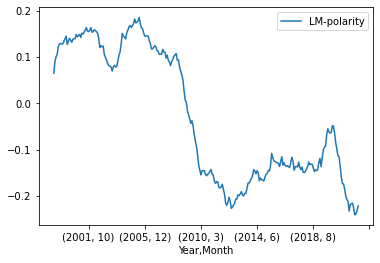

In [25]:
df2=df1.rolling(20).mean() #moyenne mobile sur 20 mois
fig=df2.plot(y="LM-polarity")

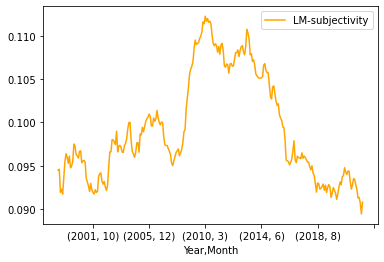

In [26]:
fig=df2.plot(y="LM-subjectivity", color='orange')

In [27]:
df.rolling(20, on="date").mean() #moyenne mobile sur 20 jours

,date,Day,DayofWeek,LM-polarity,LM-subjectivity,Month,Year,afinn-score
0,2021-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2329,1997-05-13,17.65,3.05,0.098085,0.087980,7.10,1997.25,117.85
2330,1997-04-30,18.90,3.00,0.092770,0.087755,7.20,1997.20,113.00
2331,1997-04-22,18.50,2.85,0.089275,0.089940,7.35,1997.15,109.60
2332,1997-03-10,17.90,2.70,0.076590,0.090130,7.45,1997.10,108.15


In [28]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=90
fig=df.rolling(val, on="date").mean().plot(x="date",y="LM-polarity",backend='plotly', title="Polarité")
fig.show()

In [29]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=200
fig=df.rolling(val, on="date").mean().plot(x="date",y="LM-subjectivity",backend='plotly', title="Subjectivité")

fig.show()

Les résultas obtenus semblent cohérents.

## FED Financial Stability dictionary

In [31]:
#FS Dictionary
fed1=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=1)

In [32]:
fed1
#ce format de dataframe n'est pas facile à exploiter
#on va le transformer en deux listes

,Word,Positive,Negative
0,able,1.0,NaN
1,abnormally,NaN,1.0
2,abrupt,NaN,1.0
3,absorb,1.0,NaN
4,absorbed,1.0,NaN
...,...,...,...
386,worsen,NaN,1.0
387,worsened,NaN,1.0
388,worsening,NaN,1.0
389,worst,NaN,1.0


In [33]:
positive_words=fed1[fed1["Positive"].notna()]["Word"]
positive_list=positive_words.values.tolist()
#positive_list

In [34]:
negative_words=fed1[fed1["Negative"].notna()]["Word"]
negative_list=negative_words.values.tolist()
#negative_list

In [35]:
#FS Dictionary print
fed2=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=2)
fed2
#on retrouve sous un autre format les mêmes informations que le premier dataframe

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Positive words,NaN,NaN,Negative words,NaN,NaN,NaN,NaN,NaN
1,able,mitigated,NaN,abnormally,destabilizing,exhausted,jeopardised,shortage,threats
2,absorb,mitigates,NaN,abrupt,deteriorate,expose,jeopardising,shortages,tough
3,absorbed,mitigating,NaN,abundant,deteriorated,exposed,jeopardize,shortfall,troubled
4,absorbing,mitigation,NaN,adverse,deteriorating,exposes,lackluster,shortfalls,tumbling
5,acceptable,opportunity,NaN,adversely,deterioration,exposing,lacklustre,shrank,turbulence
6,achievement,optimism,NaN,aggravate,deteriorations,fail,lagged,shrink,turbulences
7,adequately,outperformed,NaN,aggravated,detrimental,failed,lose,shrinking,turbulent
8,alleviated,positive,NaN,aggravating,difficult,failing,losing,shrunk,turmoil
9,alleviating,positively,NaN,aggravation,difficulties,fails,losses,slid,unable


In [36]:
#Non FS words
fed3=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=3)
fed3

,Word,Non-FS (neutral),
0,abandoned,1,NaN
1,abate,1,NaN
2,abated,1,NaN
3,abnormal,1,NaN
4,abolition,1,NaN
...,...,...,...
1088,underpriced,1,NaN
1089,unfolded,1,NaN
1090,unnecessary,1,NaN
1091,uplift,1,NaN


In [37]:
neutral_list=fed3["Word"].values.tolist()
#neutral_list

### Calcul des deux grandeurs : FSS index et excitement index

Ces deux grandeurs sont celles mentionnées dans le rapport associé au dictionnaire de la FED. (federalreserve.gov/econres/ifdp/files/ifdp1203.pdf)

FSS index : $$   FSS=(Negativewords - Positivewords)/(Totalwords) $$

Excitement index : $$   FSS*=(Negativewords^2 + Positivewords^2)/(Totalwords) $$

In [42]:
def FSS_index(text,positive_words=positive_list,negative_words=negative_list):
    '''Pour calculer le FSS index décrit dans le rapport de la FED'''
    '''FSS=(Negativewords - Positivewords)/(Totalwords)'''
    #positive_words et negative_words sont des listes
    negative_count=0
    positive_count=0
    L=basic_nlp.liste_mots(text)
    for word in L:
        if (word in positive_words):
            positive_count+=1
        elif (word in negative_words):
            negative_count+=1
    return round((negative_count-positive_count)*100/len(L),3)

In [43]:
def excitement_index(text,positive_words=positive_list,negative_words=negative_list):
    '''Pour calculer l'excitement index décrit dans le rapport de la FED'''
    '''FSS*=(Negativewords^2 + Positivewords^2)/(Totalwords)'''
    #positive_words et negative_words sont des listes
    negative_count=0
    positive_count=0
    L=liste_mots(text)
    for word in L:
        if (word in positive_words):
            positive_count+=1
        elif (word in negative_words):
            negative_count+=1
    return round((negative_count**2+positive_count**2)/len(L),3)

In [44]:
start=time.time()

df["FSS-index"]=df["contents"].apply(FSS_index)

print("Temps pris :",time.time()-start) #41.49177670478821

Temps pris : 44.84216570854187


In [45]:
start=time.time()

df["excitement-index"]=df["contents"].apply(excitement_index)

print("Temps pris :",time.time()-start) #43.82283163070679

Temps pris : 35.41240930557251


In [46]:
fig = px.line(df, x="date",y=["FSS-index","excitement-index"])
fig.show()

In [47]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=300
fig=df.rolling(val, on="date").mean().plot(x="date",y="FSS-index",backend='plotly', title="FSS-index")

fig.show()

In [48]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=300
fig=df.rolling(val, on="date").mean().plot(x="date",y="excitement-index",backend='plotly', title="excitement-index")

fig.show()

## Dataset "financial_phrasebank"

In [ ]:
dataset = datasets.load_dataset("financial_phrasebank", 'sentences_allagree')

In [ ]:
pd.DataFrame.from_dict(dataset)

# Régression linéaire et random forest

In [10]:
url = "https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/sentiment_analysis_speeches_dataset.csv"

df = pd.read_csv(url,sep = ",",encoding='utf-8', index_col = ["date"])


In [11]:
df.index.rename("Date")
df = df.drop(columns=['Unnamed: 0','title','subtitle','contents'])
df["speakers"] = le.fit_transform(df["speakers"])
features = df[["speakers","Year","Month","Day","DayofWeek","textblob-score"]].groupby("Date").mean()
df

,speakers,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index
date,,,,,,,,,,,,,
2021-12-10,Fabio Panetta,2021,12,10,5,Friday,December,98.0,0.058202,-0.1379,0.0924,0.450,0.725
2021-12-08,Isabel Schnabel,2021,12,8,3,Wednesday,December,-67.0,0.074981,-0.2604,0.1302,0.878,2.173
2021-12-08,Luis de Guindos,2021,12,8,3,Wednesday,December,10.0,0.104165,-0.2621,0.1287,0.731,1.084
2021-12-08,Christine Lagarde,2021,12,8,3,Wednesday,December,-48.0,0.085205,-0.3043,0.1443,2.308,1.012
2021-11-29,Christine Lagarde,2021,11,29,1,Monday,November,47.0,0.118910,-0.1719,0.0831,0.979,0.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-05-13,Alexandre Lamfalussy,1997,5,13,2,Tuesday,May,107.0,0.072848,-0.0984,0.0993,0.327,0.283
1997-04-30,Alexandre Lamfalussy,1997,4,30,3,Wednesday,April,118.0,0.090242,0.1111,0.0736,-0.292,0.149
1997-04-22,Alexandre Lamfalussy,1997,4,22,2,Tuesday,April,95.0,0.077731,-0.0074,0.1133,0.477,0.589


In [ ]:
le = preprocessing.LabelEncoder()
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)

In [ ]:
df["speakers"] = le.fit_transform(df["speakers"])

In [9]:
estx50='^STOXX50E'
#récupération des données
data=yf.Ticker(estx50)
#récupération prix
estx50_df= data.history(periode='1d', start='1997-01-01', end='2022-01-05')

estx50_df['HML']=estx50_df['High']-estx50_df['Low'] #High minus Low
estx50_df['CMO']=estx50_df['Close']-estx50_df['Open'] #Close minus Open
estx50_df['Daily Variation']=estx50_df.apply(lambda row: 100*(row.Close - row.Open)/row.Open, axis = 1)
estx50_df['Daily Volatility']=estx50_df.apply(lambda row: 100*abs(row.CMO)/row.Open, axis = 1)
estx50_df['HML Volatility']=estx50_df.apply(lambda row: 100*abs(row.HML)/row.Open, axis = 1)
estx50_df=estx50_df.drop(columns=['Open','High','Low','Close','Volume','Dividends','Stock Splits'])

#afficher les données
estx50_df

Index(['2021-12-10', '2021-12-08', '2021-12-08', '2021-12-08', '2021-11-29',
       '2021-11-26', '2021-11-25', '2021-11-24', '2021-11-22', '2021-11-19',
       ...
       '1997-09-22', '1997-09-12', '1997-06-30', '1997-06-30', '1997-06-02',
       '1997-05-13', '1997-04-30', '1997-04-22', '1997-03-10', '1997-02-07'],
      dtype='object', name='date', length=2334)

In [ ]:
eurusd_df=yf.download('EURUSD=X')
eurusd_df['HML']=eurusd_df['High']-eurusd_df['Low'] #High minus Low
eurusd_df['CMO']=eurusd_df['Close']-eurusd_df['Open'] #Close minus Open
eurusd_df['Daily Variation']=eurusd_df.apply(lambda row: 100*(row.Close - row.Open)/row.Open, axis = 1)
eurusd_df['Daily Volatility']=eurusd_df.apply(lambda row: 100*abs(row.CMO)/row.Open, axis = 1)
eurusd_df['HML Volatility']=eurusd_df.apply(lambda row: 100*abs(row.HML)/row.Open, axis = 1)
eurusd_df=eurusd_df.drop(columns=['Open','High','Low','Close','Adj Close'])
eurusd_df

In [ ]:
df1=daily_df.join(eurusd_df)
df1=df1.dropna()
df1

In [ ]:
df2=daily_df.join(estx50_df)
df2=df1.dropna()
df2

In [ ]:
# To find the correlation among
# the columns using pearson method
df1.corr(method ='pearson')
#df1.corr(method ='kendall')

In [ ]:
df2.corr(method ='pearson')

In [ ]:
Y_train = target[1:1200]
Y_test = target[1200:]
X_train = data.iloc[:1199]
X_test = data.iloc[1199:-1]

In [ ]:
lr = lr.fit(X_train, Y_train)
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, lr.predict(X_test))